In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy.interpolate import interp1d
import random

In [221]:
class DataCreation():
    def __init__(self, sample_size, timestamps):
        self.sample_size = sample_size
        self.timestamps = timestamps
        
    def create_intervals(self, seed):        
        random.seed(seed+100)
        intervals = []
        i = 0
        while i <= self.timestamps:
            length = random.randint(200, 1000)
            if (i + length + 400) > self.timestamps:
                sublist = list((i, self.timestamps))
                intervals.append(sublist)
                break
            else:
                sublist = list((i, i+length-1))
            intervals.append(sublist)
            i = i + length
        return intervals
    
    def create_df(self, seed):
        self.f_x = np.array([])
        
        partitions_1 = self.create_intervals(seed)
        partitions_2 = self.create_intervals(seed+1)
        random.seed(seed)
        for i in range(len(partitions_1)):
            freq = random.choice([6, 8])
            co_ef = random.uniform(8, 10)
            self.f_x = np.append(self.f_x, co_ef * np.sin(np.linspace(0, freq * np.pi, partitions_1[i][1] - partitions_1[i][0] + 1)))

        for i in range(len(partitions_2)):
            mean = 0
            variance = random.uniform(0.1, 2)
            self.f_x[partitions_2[i][0]:partitions_2[i][1]] = self.f_x[partitions_2[i][0]:partitions_2[i][1]] + np.random.normal(mean, variance, partitions_2[i][1] - partitions_2[i][0])
        
        self.f_x = self.f_x[:self.timestamps]
        return self.f_x
    
    def train_test_split(self, split):
        g_x = self.f_x.reshape(self.timestamps // self.sample_size, self.sample_size)
        split = round(len(g_x) * split)
        self.train_X = g_x[:split]
        self.test_X = g_x[split:]
        
    def faulty_point_data(self, test_data, seed):
        test_data_reshaped = test_data.reshape(test_data.shape[0] * test_data.shape[1])
        random.seed(seed)
        num_anomalies = random.randint(1000, 1500)
        self.normal_timestamps = [i for i in range(len(test_data_reshaped))]
        self.anomaly_timestamps = []
        for i in range(num_anomalies):
            anomaly = random.choice(self.normal_timestamps)
            self.anomaly_timestamps.append(anomaly)
            self.normal_timestamps.remove(anomaly)
        for anomaly in self.anomaly_timestamps:
            if anomaly < 50:
                mean, std = test_data_reshaped[anomaly:anomaly+50].mean(), test_data_reshaped[anomaly:anomaly+50].std()
                if random.choice([0, 1]) == 1:
                    test_data_reshaped[anomaly] = mean + random.uniform(3*std, 3.5*std)
                else:
                    test_data_reshaped[anomaly] = mean - random.uniform(3*std, 3.5*std)
            elif anomaly > len(test_data_reshaped)-50:
                mean, std = test_data_reshaped[anomaly-50:anomaly].mean(), test_data_reshaped[anomaly-50:anomaly].std()
                if random.choice([0, 1]) == 1:
                    test_data_reshaped[anomaly] = mean + random.uniform(3*std, 3.5*std)
                else:
                    test_data_reshaped[anomaly] = mean - random.uniform(3*std, 3.5*std)
            else:
                mean, std = test_data_reshaped[anomaly-25:anomaly+25].mean(), test_data_reshaped[anomaly-25:anomaly+25].std()
                if random.choice([0, 1]) == 1:
                    test_data_reshaped[anomaly] = mean + random.uniform(3*std, 3.5*std)
                else:
                    test_data_reshaped[anomaly] = mean - random.uniform(3*std, 3.5*std)
        return test_data_reshaped
    
    def faulty_collective_data(self, data, num_anomalies, seed):
        random.seed(seed)
        self.anomaly_timestamps = []
        self.normal_timestamps = [i for i in range(len(data))]
        for i in range(num_anomalies):
            anomaly = random.randint(i*(len(data)//num_anomalies), (i+1)*(len(data)//num_anomalies)-100)
            self.anomaly_timestamps.append(anomaly)           
            self.normal_timestamps.remove(anomaly)
        for anomaly in self.anomaly_timestamps:
            data[anomaly:anomaly+100] = data[anomaly]
        return data
            
    def plot_df(self, sample, size):
        plt.figure(figsize=(12, 6))
        plt.plot(self.f_x)
        plt.xlim([sample*size, sample*size + size])

#### Point Anomaly

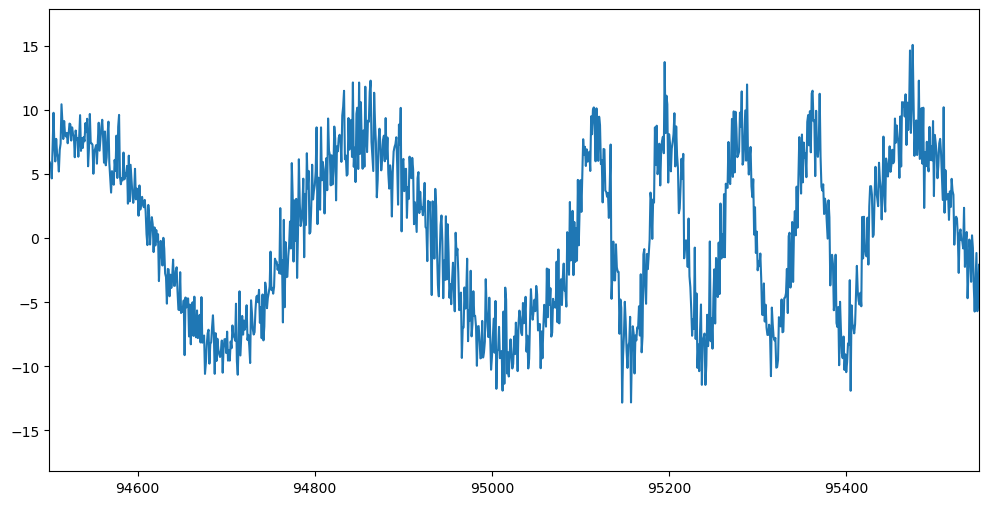

In [72]:
sample_size, timestamps = 500, 500000
data = DataCreation(sample_size, timestamps)
f_x = data.create_df(200)
data.train_test_split(0.8)
train_X = data.train_X
test_X = data.test_X
data.plot_df(90, 1050)

In [73]:
test_X = data.faulty_point_data(test_X, 14000)

In [206]:
def evaluate_MA(data, window_size, timestamps):
    interval = window_size // 2
    moving_average = [np.nan for i in range(interval)]
    standard_dev = [np.nan for i in range(interval)]
    for i in range(interval, timestamps - interval):
        window = data[i - interval:i + interval]
        window_median = np.mean(window)
        standard_dev.append(np.std(np.array(window)))
        moving_average.append(window_median)
    anomalies = []
    for i in range(window_size//2, timestamps - window_size):
        threshold_1 = moving_average[i] + 3 * standard_dev[i]
        threshold_2 = moving_average[i] - 3 * standard_dev[i]
        if data[i] > threshold_1 or data[i] < threshold_2:
            anomalies.append(i)
    anomalies = np.array(anomalies)
    return anomalies

In [ ]:
p, r, f1 = [], [], []
for window_size in range(15, 200):
    times = set([i for i in range(len(test_X))])
    anomalies = evaluate_MA(test_X, window_size, timestamps=len(test_X))
    tp = np.sum(np.isin(data.anomaly_timestamps, anomalies))
    fp = np.sum(np.isin(data.normal_timestamps, anomalies))
    tn = np.sum(np.isin(np.array(list(times - set(anomalies))), anomalies))
    fn = np.sum(np.isin(np.array(list(times - set(anomalies))), data.anomaly_timestamps))
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    p.append(precision)
    r.append(recall)
    f1.append(2 * ((precision * recall) / (precision + recall)))

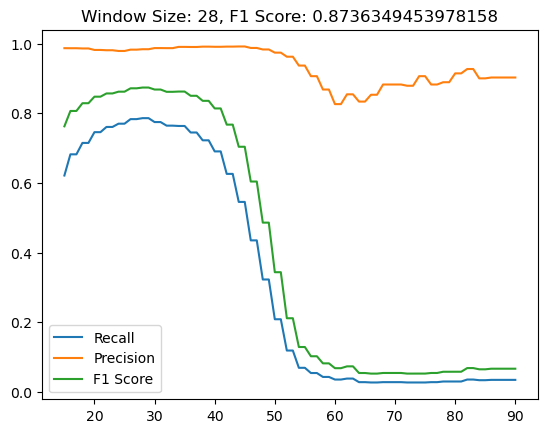

In [208]:
plt.title(f"Window Size: {15+f1.index(max(f1))}, F1 Score: {max(f1)}")
x = [15+i for i in range(len(r))]
plt.plot(x, r, label="Recall")
plt.plot(x, p, label="Precision")
plt.plot(x, f1, label="F1 Score")
plt.legend()
plt.show()

In [216]:
timestamps = len(test_X)
window_size = 56
medians = np.zeros(window_size // 2).tolist()
standard_dev = np.zeros(window_size // 2).tolist()
for i in range(window_size, timestamps):
    window = test_X[i-window_size:i]
    window_median = np.median(window)
    standard_dev.append(stats.median_abs_deviation(np.array(window)))
    medians.append(window_median)

In [217]:
anomalies, lb, ub = [], np.zeros(window_size // 2).tolist(), np.zeros(window_size // 2).tolist()
for i in range(window_size//2, timestamps - window_size):
    threshold_1 = medians[i] + 3 * standard_dev[i]
    threshold_2 = medians[i] - 3 * standard_dev[i]
    if test_X[i] > threshold_1 or test_X[i] < threshold_2:
        anomalies.append(i)
    lb.append(threshold_2)
    ub.append(threshold_1)
np.array(anomalies)[:5]

array([234, 275, 376, 381, 492])

In [218]:
print(f"Accuractely Detected Anomalies out of {len(data.anomaly_timestamps)}: {np.sum(np.isin(data.anomaly_timestamps, anomalies))}")
print(f"False Alarms out of {len(data.normal_timestamps)}: {np.sum(np.isin(data.normal_timestamps, anomalies))}")

Accuractely Detected Anomalies out of 1069: 1030
False Alarms out of 98931: 510


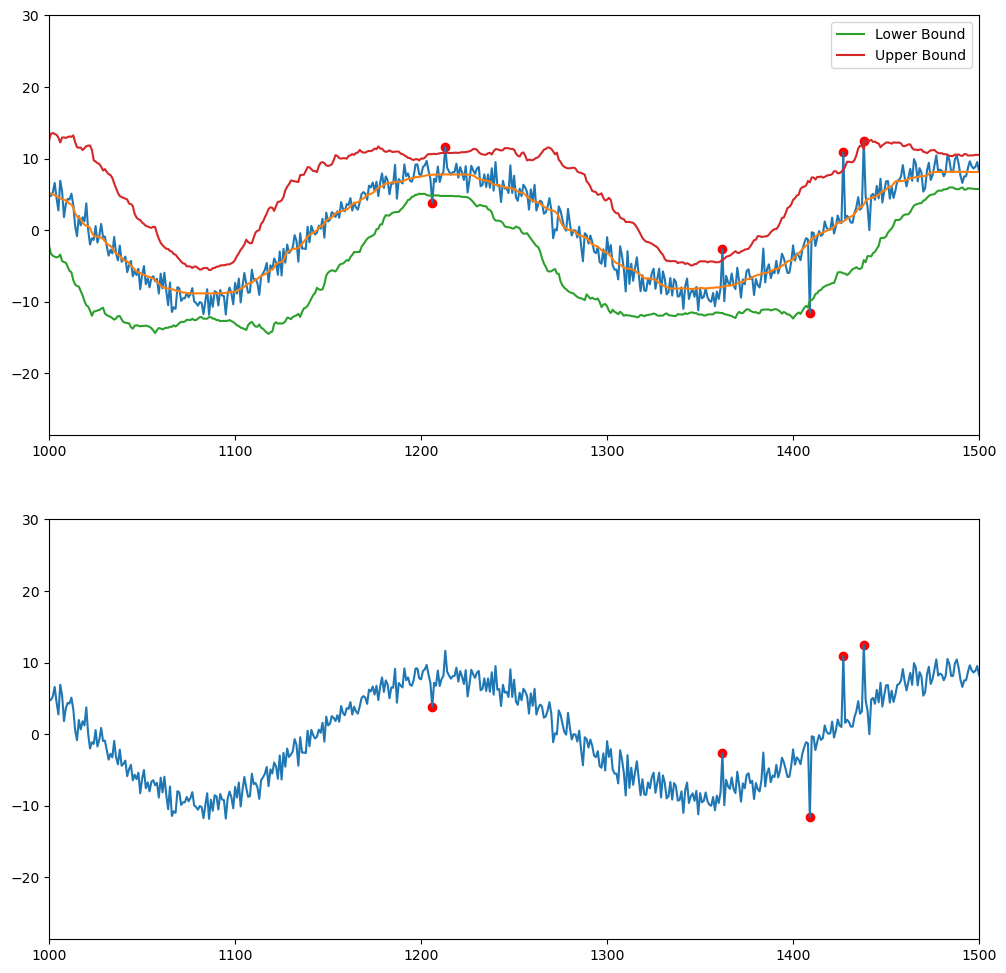

In [220]:
i = 1
plt.figure(figsize=(12, 12))
plt.subplot(211)
plt.plot(test_X)
plt.plot(medians)
plt.plot(lb, label='Lower Bound')
plt.plot(ub, label='Upper Bound')
plt.legend()
plt.scatter(anomalies, test_X[anomalies], color='red')
plt.xlim([i*1000, i*1000 + 500])
plt.subplot(212)
plt.plot(test_X)
plt.scatter(data.anomaly_timestamps, test_X[data.anomaly_timestamps], color='r')
plt.xlim([i*1000, i*1000 + 500])
plt.show()

#### Collective Anomaly

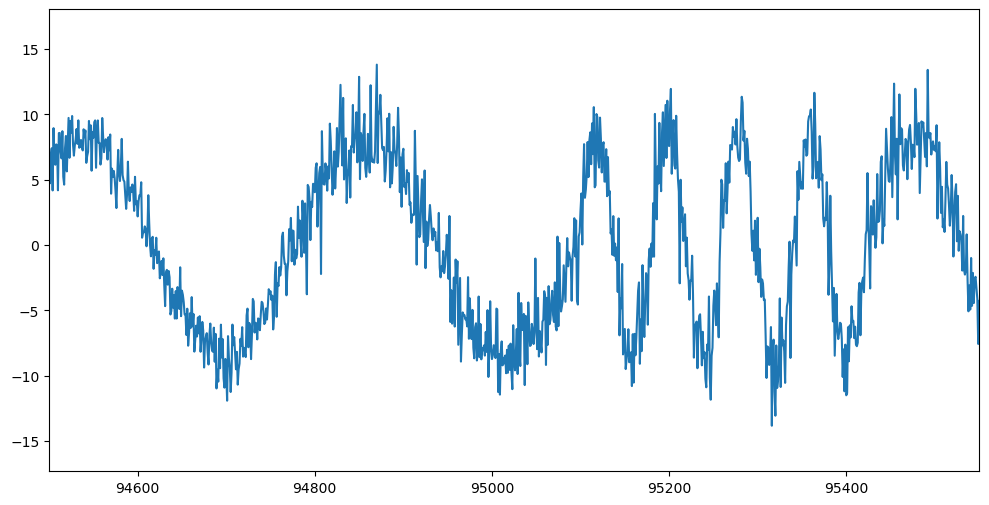

In [64]:
sample_size, timestamps = 500, 500000
data = DataCreation(sample_size, timestamps)
f_x = data.create_df(200)
data.train_test_split(0.8)
train_X = data.train_X
test_X = data.test_X
test_X = test_X.reshape(test_X.shape[0] * test_X.shape[1])
data.plot_df(90, 1050)

In [65]:
test_X = data.faulty_collective_data(test_X, 100, 1)

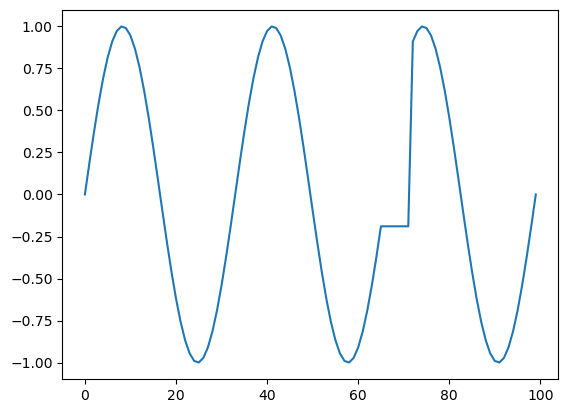

In [137]:
x_0 = np.sin(np.linspace(0, 6 * np.pi, 100))
x_0[65:72] = x_0[65]
# x_0 = x_0 + np.random.normal(0, 0.1, 100)
plt.plot(x_0)
plt.show()

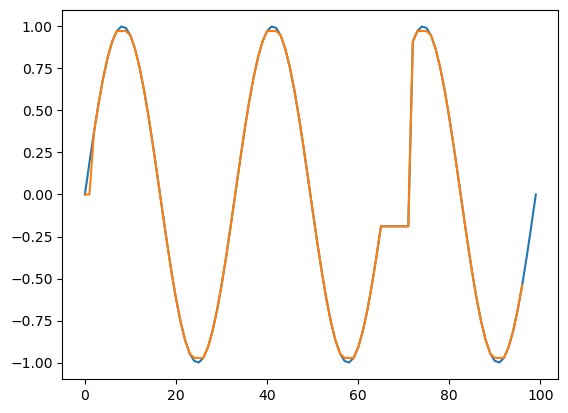

In [143]:
timestamps = 100
window_size = 5
medians = np.zeros(window_size // 2).tolist()
standard_dev = np.zeros(window_size // 2).tolist()
for i in range(window_size, timestamps):
    window = x_0[i-window_size:i]
    window_median = np.median(window)
    standard_dev.append(stats.median_abs_deviation(np.array(window)))
    medians.append(window_median)
plt.plot(x_0)
plt.plot(medians)

In [133]:
anomalies, lb, ub = [], np.zeros(window_size//2).tolist(), np.zeros(window_size//2).tolist()
for i in range(window_size//2, timestamps - window_size):
    threshold_1 = medians[i] + 3 * standard_dev[i]
    threshold_2 = medians[i] - 3 * standard_dev[i]
    if x_0[i] > threshold_1 or x_0[i] < threshold_2:
        anomalies.append(i)
    lb.append(threshold_2)
    ub.append(threshold_1)
np.array(anomalies)[:5]

array([ 8, 39, 58, 60, 67])

In [134]:
len(medians)

95

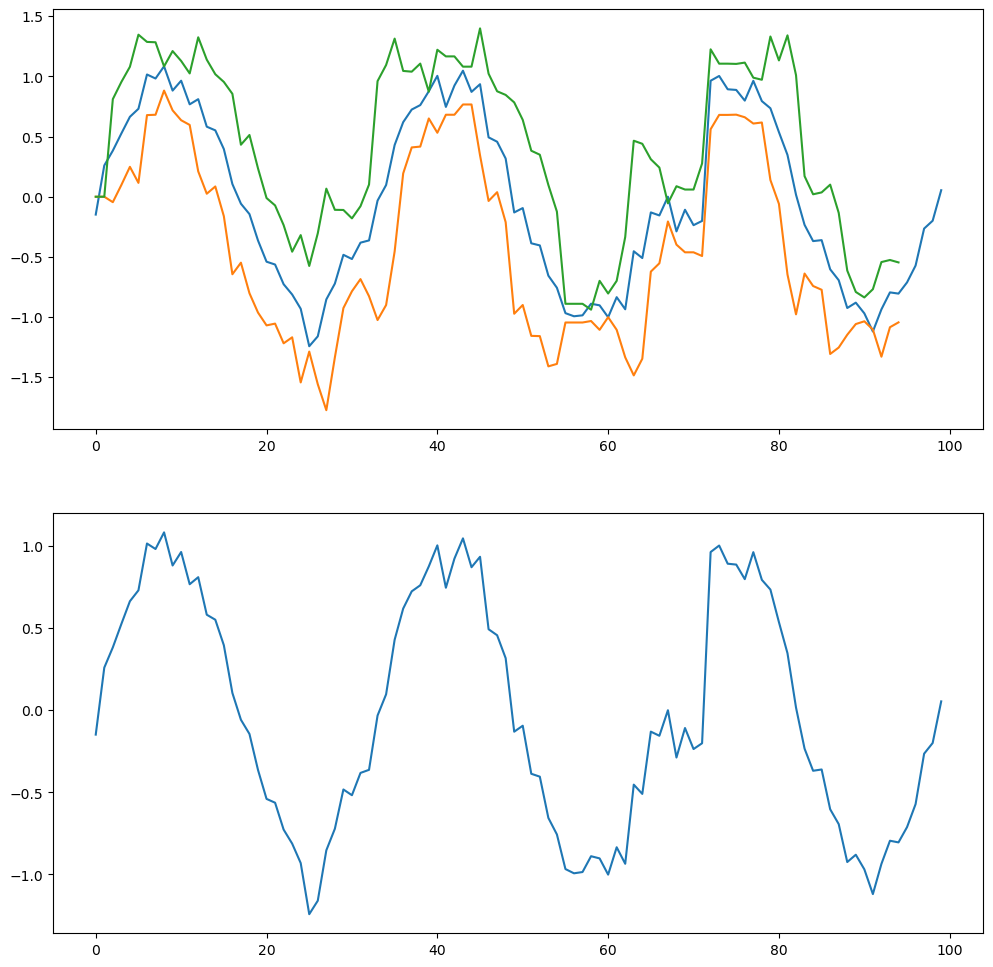

In [136]:
i = 0
plt.figure(figsize=(12, 12))
plt.subplot(211)
plt.plot(x_0)
# plt.plot(medians)
plt.plot(lb)
plt.plot(ub)
# plt.scatter(anomalies, x_0[anomalies], color='red')
plt.subplot(212)
plt.plot(x_0)
plt.show()

In [189]:
import rrcf
import pandas as pd

In [190]:
df = pd.DataFrame({'time 2': x_0})
df['time 1'] = df['time 2'].shift(-1)
df['time 0'] = df['time 1'].shift(-1)
df = df[:98]
X = np.array(df)
X

array([[ 0.00000000e+00,  1.89251244e-01,  3.71662456e-01],
       [ 1.89251244e-01,  3.71662456e-01,  5.40640817e-01],
       [ 3.71662456e-01,  5.40640817e-01,  6.90079011e-01],
       [ 5.40640817e-01,  6.90079011e-01,  8.14575952e-01],
       [ 6.90079011e-01,  8.14575952e-01,  9.09631995e-01],
       [ 8.14575952e-01,  9.09631995e-01,  9.71811568e-01],
       [ 9.09631995e-01,  9.71811568e-01,  9.98867339e-01],
       [ 9.71811568e-01,  9.98867339e-01,  9.89821442e-01],
       [ 9.98867339e-01,  9.89821442e-01,  9.45000819e-01],
       [ 9.89821442e-01,  9.45000819e-01,  8.66025404e-01],
       [ 9.45000819e-01,  8.66025404e-01,  7.55749574e-01],
       [ 8.66025404e-01,  7.55749574e-01,  6.18158986e-01],
       [ 7.55749574e-01,  6.18158986e-01,  4.58226522e-01],
       [ 6.18158986e-01,  4.58226522e-01,  2.81732557e-01],
       [ 4.58226522e-01,  2.81732557e-01,  9.50560433e-02],
       [ 2.81732557e-01,  9.50560433e-02, -9.50560433e-02],
       [ 9.50560433e-02, -9.50560433e-02

In [193]:
tree = rrcf.RCTree(X)
codisp = []
for i in range(len(X)):
    codisp.append(tree.codisp(i))

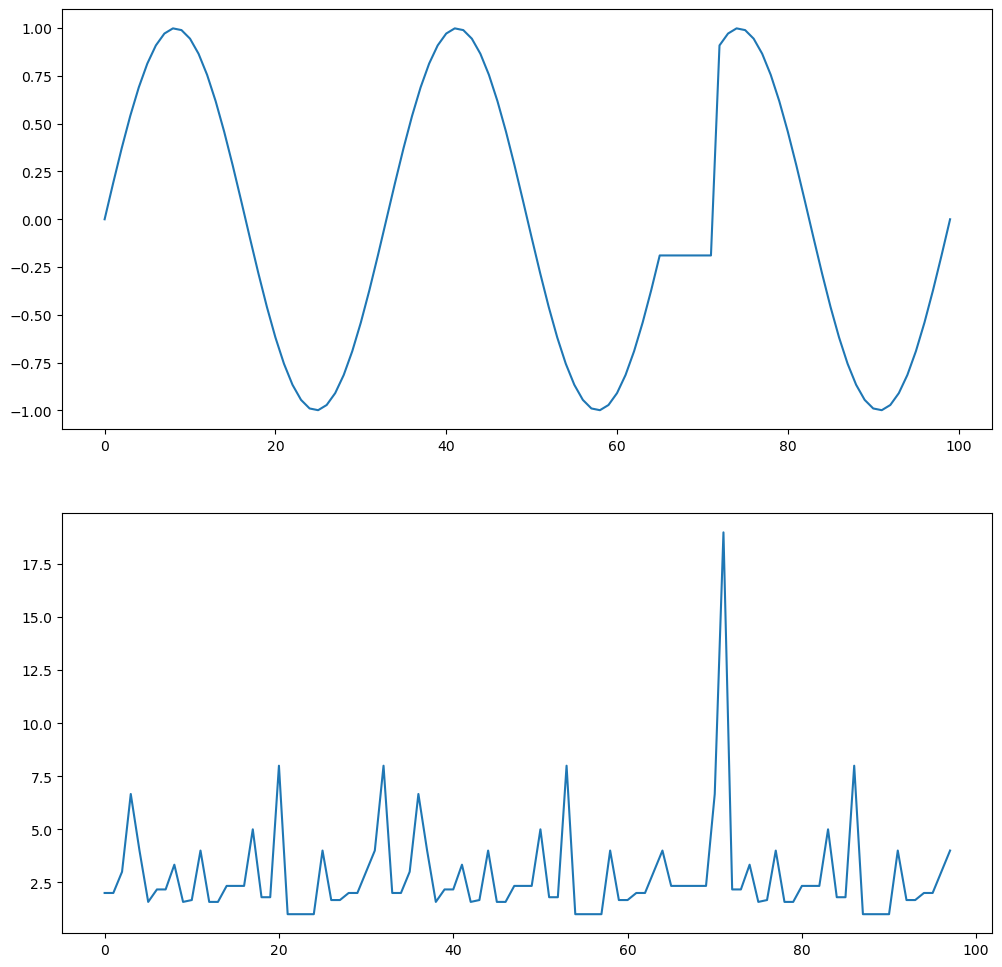

In [194]:
plt.figure(figsize=(12, 12))
plt.subplot(211)
plt.plot(x_0)
plt.subplot(212)
plt.plot(codisp)
plt.show()